In [1]:
import geopandas as gpd
from pyproj import Proj, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

In [2]:
# df = pd.read_fwf('SUEWS_SiteSelect_sorted.txt')
# df.columns=df.iloc[0]
# df=df.reindex(df.index.drop(0))
# df.drop(df.tail(2).index,inplace=True)
# df= df.astype(float)
# lat=df['lat']
# lon=df['lng']

In [3]:
# df = pd.read_csv('SUEWS_SiteSelect_v2017_2m_wall_limit.txt',sep='\t')
# df.columns=df.iloc[0]
# df=df.reindex(df.index.drop(0))
# df.drop(df.tail(2).index,inplace=True)
# df= df.astype(float)
# lat=df['lat']
# lon=df['lng']

In [4]:
df = pd.read_csv('SUEWS_SiteSelect.txt',sep='\t')
df.columns=df.iloc[0]
df=df.drop(df.index[0])
df.drop(df.tail(2).index,inplace=True)
df= df.astype(float)
lat=df['lat']
lon=df['lng']

/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,,"(Grid, Year, StartDLS)",EndDLS,lat,lng,SurfaceArea,Alt,id,ih,imin,Fr_Paved,Fr_Bldgs,...,Fr_ESTMClass_Bldgs5,Code_ESTMClass_Bldgs1,Code_ESTMClass_Bldgs2,Code_ESTMClass_Bldgs3,Code_ESTMClass_Bldgs4,Code_ESTMClass_Bldgs5,!,Site,Reference,nan
13203,2015,85,302.0,51.2844,0.108142,1.0,0.0,1.0,0.0,0.0,0.581000,0.0,...,0.0,801.0,803.0,8021.0,8022.0,8041.0,NaN,NaN,NaN,NaN
13366,2015,85,302.0,51.2844,0.106710,1.0,0.0,1.0,0.0,0.0,0.885000,0.0,...,0.0,801.0,803.0,8021.0,8022.0,8041.0,NaN,NaN,NaN,NaN
13376,2015,85,302.0,51.2937,0.120468,1.0,0.0,1.0,0.0,0.0,0.000000,0.0,...,0.0,801.0,803.0,8021.0,8022.0,8041.0,NaN,NaN,NaN,NaN
13530,2015,85,302.0,51.2843,0.105278,1.0,0.0,1.0,0.0,0.0,0.387000,0.0,...,0.0,801.0,803.0,8021.0,8022.0,8041.0,NaN,NaN,NaN,NaN
13539,2015,85,302.0,51.2927,0.117660,1.0,0.0,1.0,0.0,0.0,0.022022,0.0,...,0.0,801.0,803.0,8021.0,8022.0,8041.0,NaN,NaN,NaN,NaN


In [6]:
# p2_text='''
# +units=m +init=ESRI:102009 +proj=lcc +lat_1=30 +lat_2=60 +lat_0=51.51 +lon_0=0.13 
# +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0
# '''

p2_text='''
+units=m +init=ESRI:102009 +proj=lcc +lat_1=30 +lat_2=60 +lat_0=51.51 +lon_0=-0.96 
+x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0
'''

p1 = Proj(init='epsg:32631')
p2 = Proj(p2_text)
x1, y1 = p1(list(lon),list(lat))
x2, y2 = transform(p1,p2,x1,y1)

In [7]:
x_file='wrfinput_d03.suews'
ds_base = xr.open_dataset(x_file)
wrf_LAT=ds_base.XLAT.values[0,:,:]
wrf_LON=ds_base.XLONG.values[0,:,:]


wrf_X,wrf_Y=p2(wrf_LON,wrf_LAT)

In [8]:
def pc_plot(grid_x, grid_y,new_Z,name):
    plt.figure(figsize=(10,10))
    plt.pcolor(grid_x, grid_y,new_Z)
    plt.colorbar()
    plt.title(name)
    plt.ylabel('y')
    plt.xlabel('x')
    

In [9]:
def regrid_lower(name):
    Z=df[name]
    grid_x=wrf_X
    grid_y=wrf_Y
    new_Z=griddata(list(zip(x2,y2)), Z.values, (grid_x, grid_y), method='linear')
    #pc_plot(grid_x, grid_y,new_Z,name)
    return grid_x, grid_y,new_Z

In [10]:
names=['H_Bldgs','H_EveTr','H_DecTr']
names_wrf=['bldgH_SUEWS','EveTreeH_SUEWS','DecTreeH_SUEWS']

for name,name_wrf in zip(names,names_wrf):
    print(name)
    grid_x, grid_y,new_0=regrid_lower(name)
    #new_all.update( {name : new_0} )
    ds_var=ds_base[name_wrf.upper()].values[0,:,:]
    ds_var[~np.isnan(new_0)]=new_0[~np.isnan(new_0)]
    zz=ds_base[name_wrf.upper()].values[0,:,:]
    zz[zz<0]=0
    ds_base[name_wrf.upper()].values[0,:,:]=zz

H_Bldgs
H_EveTr
H_DecTr


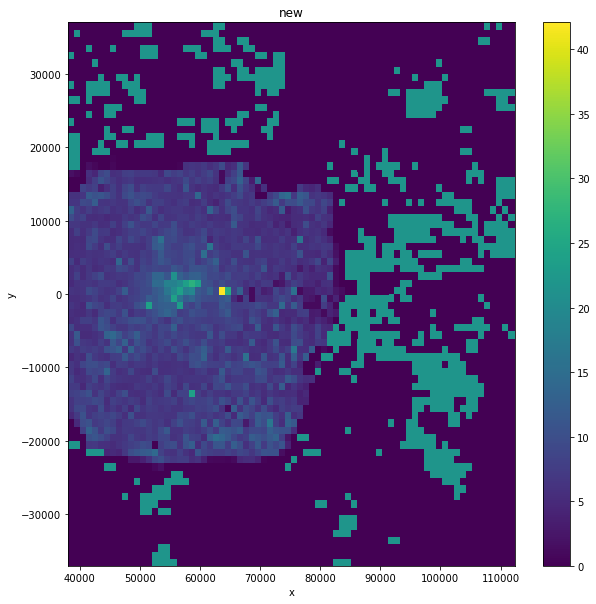

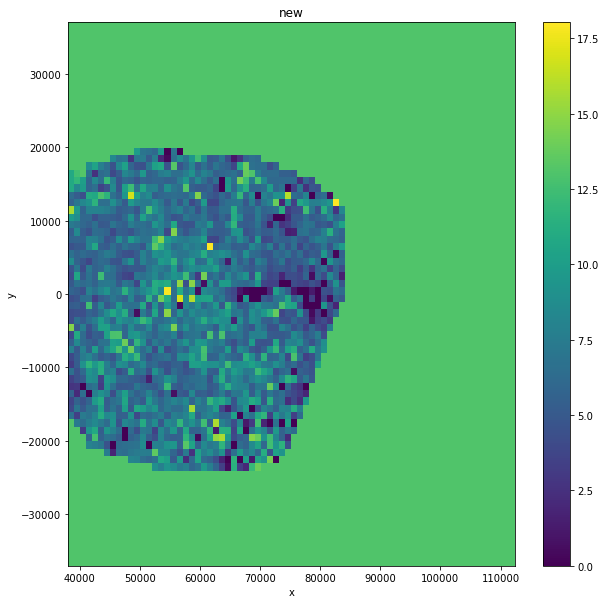

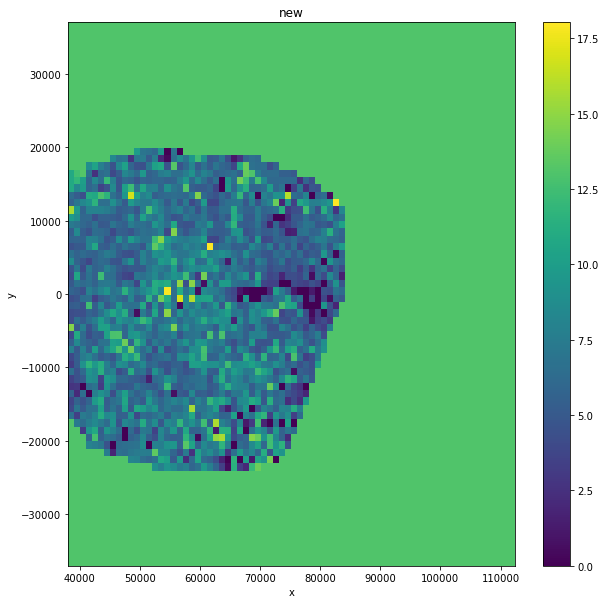

In [11]:
for name_wrf in names_wrf:
    pc_plot(wrf_X, wrf_Y,ds_base[name_wrf.upper()].values[0,:,:],'new')

In [12]:
# names=['PopDensNight','PopDensNight']
# names_wrf=['PopDensNightTime_SUEWS','PopDensDayTime_SUEWS']

# for name,name_wrf in zip(names,names_wrf):
#     print(name)
#     grid_x, grid_y,new_0=regrid_lower(name)
#     #new_all.update( {name : new_0} )
#     ds_var=ds_base[name_wrf.upper()].values[0,:,:]
#     ds_var[~np.isnan(new_0)]=new_0[~np.isnan(new_0)]
#     zz=ds_base[name_wrf.upper()].values[0,:,:]
#     zz[zz<0]=0
#     ds_base[name_wrf.upper()].values[0,:,:]=zz
# pc_plot(wrf_X, wrf_Y,ds_base['PopDensNightTime_SUEWS'.upper()].values[0,:,:],'new')

In [13]:
names=['Fr_Paved' ,'Fr_Bldgs' ,'Fr_EveTr' ,'Fr_DecTr' ,'Fr_Grass' ,'Fr_Bsoil','Fr_Water']
new_all={}
for name in names:
    print(name)
    grid_x, grid_y,new_0=regrid_lower(name)
    new_all[name]=new_0

Fr_Paved
Fr_Bldgs
Fr_EveTr
Fr_DecTr
Fr_Grass
Fr_Bsoil
Fr_Water


In [14]:
new_0=new_all['Fr_Paved']
cd=~np.isnan(new_0)
ds_base['LANDUSEF'].values[0,12,:,:][cd]=new_all['Fr_Paved'][cd]+new_all['Fr_Bldgs'][cd]

ds_base['LANDUSEF'].values[0,0,:,:][cd]=new_all['Fr_EveTr'][cd]/3
ds_base['LANDUSEF'].values[0,1,:,:][cd]=new_all['Fr_EveTr'][cd]/3
ds_base['LANDUSEF'].values[0,4,:,:][cd]=new_all['Fr_EveTr'][cd]/3

ds_base['LANDUSEF'].values[0,2,:,:][cd]=new_all['Fr_DecTr'][cd]/2
ds_base['LANDUSEF'].values[0,3,:,:][cd]=new_all['Fr_DecTr'][cd]/2

ds_base['LANDUSEF'].values[0,5,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,6,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,7,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,8,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,9,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,11,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,13,:,:][cd]=new_all['Fr_Grass'][cd]/7

ds_base['LANDUSEF'].values[0,15,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,17,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,18,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,19,:,:][cd]=new_all['Fr_Bsoil'][cd]/4


ds_base['LANDUSEF'].values[0,10,:,:][cd]=new_all['Fr_Water'][cd]/2
ds_base['LANDUSEF'].values[0,16,:,:][cd]=new_all['Fr_Water'][cd]/2

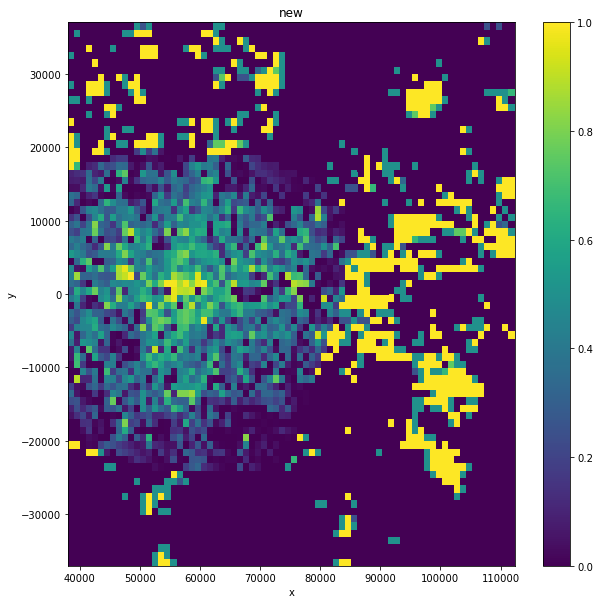

In [15]:
pc_plot(wrf_X, wrf_Y,ds_base['LANDUSEF'].values[0,12,:,:],'new')

In [16]:
shapefile2 = gpd.read_file("ESRI1/OAres_work_pop.shp")
p2_text='''ESRI:102009 +proj=lcc +lat_1=30 +lat_2=60 +lat_0=51.51 +lon_0=-0.96 
+x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0
'''
shapefile_converted=shapefile2.to_crs({'init': p2_text})
shapefile_converted['Res_dens']=shapefile_converted['ResPop']/(shapefile_converted['Area']/10000)
shapefile_converted['Work_dens']=shapefile_converted['WorkPop']/(shapefile_converted['Area']/10000)

/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


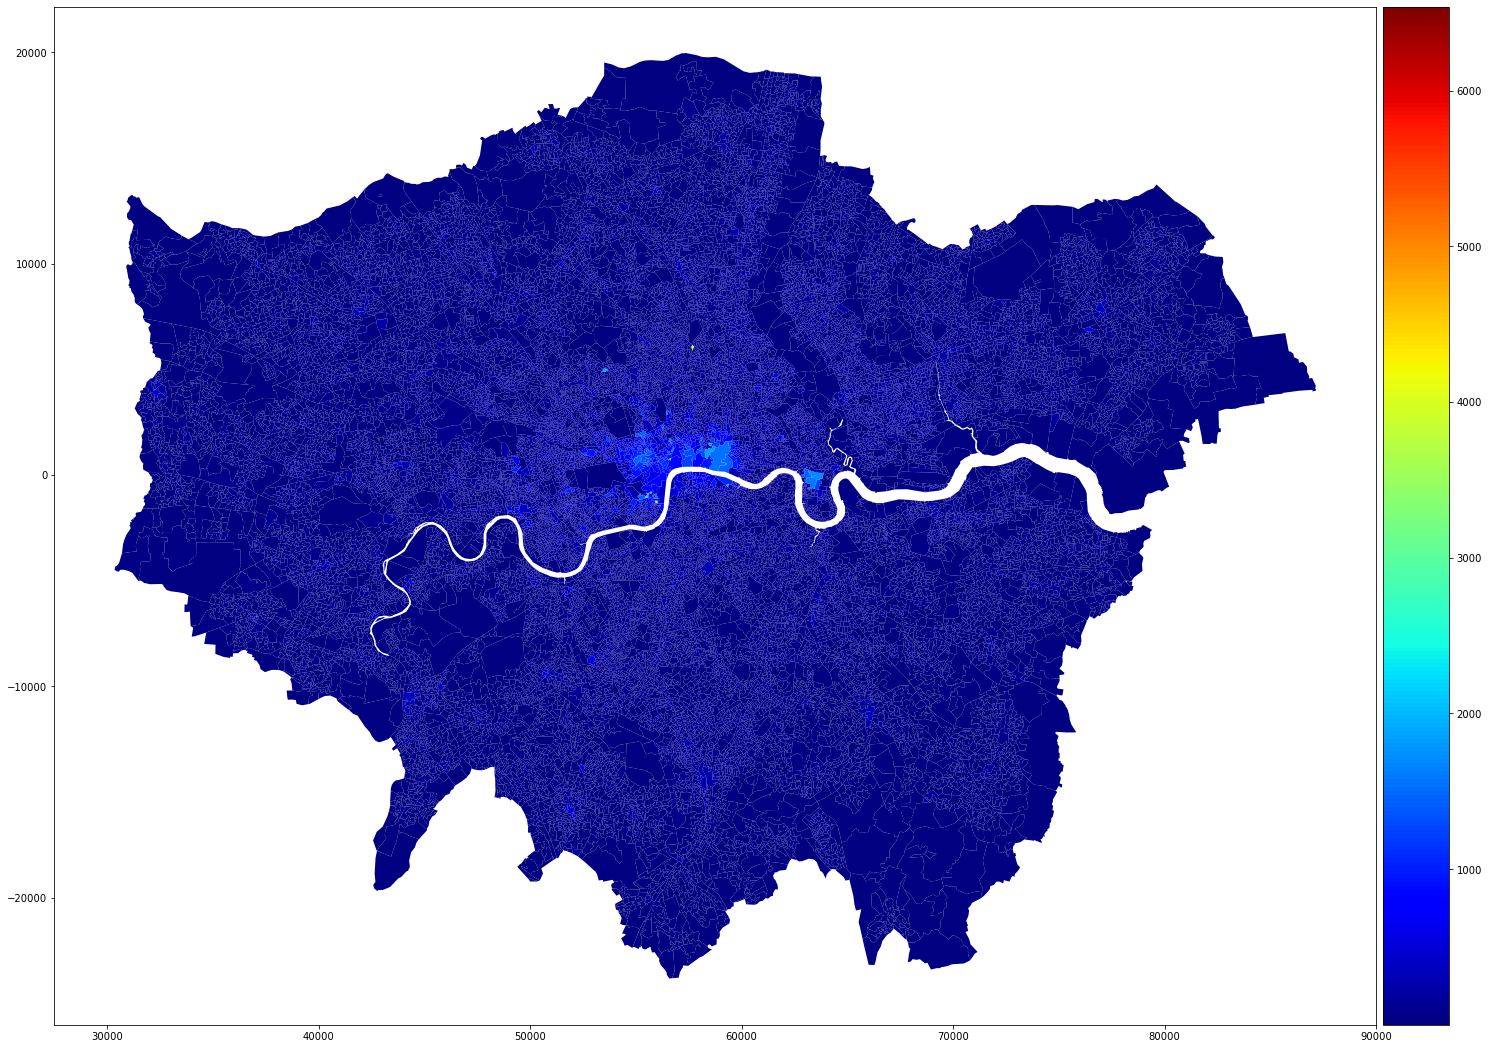

In [17]:
fig, ax = plt.subplots(1, 1,figsize=(25,25))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
shapefile_converted_2=shapefile_converted.copy()
shapefile_converted_2.loc[shapefile_converted_2[shapefile_converted_2['Work_dens']>17000].index,'Work_dens']=np.nan
shapefile_converted_2.loc[shapefile_converted_2[shapefile_converted_2['Res_dens']>17000].index,'Res_dens']=np.nan

shapefile_converted_2.plot('Work_dens',cmap='jet',ax=ax,
               legend=True, cax=cax)
plt.savefig('popdens.png',pdi=500)

In [18]:
shapefile_converted[shapefile_converted.Work_dens==shapefile_converted.Work_dens.max()]

,ID,LSOA11CD,MSOA11CD,Area,WorkPop,ResPop,geometry,Res_dens,Work_dens
25051,E00014344,E01002862,E02000590,191,331,437,POLYGON ((53447.23082508645 -1637.677372718392...,22879.581152,17329.842932


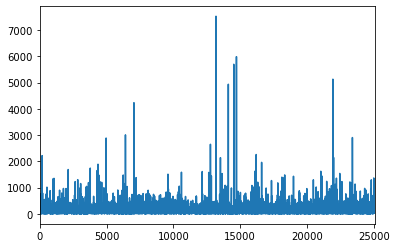

In [19]:
shapefile_converted_2.Res_dens.plot()

In [20]:
def regrid_lower_2(name,z1,x1,y1,wrf_X,wrf_Y):
    Z=z1
    grid_x=wrf_X
    grid_y=wrf_Y
    new_Z=griddata(list(zip(x1,y1)), Z, (grid_x, grid_y),method='linear')
    #pc_plot(grid_x, grid_y,new_Z,name)
    return grid_x, grid_y,new_Z

In [21]:
x1=shapefile_converted_2.iloc[:]['geometry'].centroid.x
y1=shapefile_converted_2.iloc[:]['geometry'].centroid.y
names=['Work_dens','Res_dens']
names_wrf=['PopDensDayTime_SUEWS','PopDensNightTime_SUEWS']
for name,name_wrf in zip(names,names_wrf):
    print(name)
    z1=shapefile_converted_2[name]
    grid_x, grid_y,new_0=regrid_lower_2('',z1,x1,y1,wrf_X,wrf_Y)
    xx=np.where(new_0==new_0[~np.isnan(new_0)].max())[0]
    yy=np.where(new_0==new_0[~np.isnan(new_0)].max())[1]
    new_0[new_0==new_0[~np.isnan(new_0)].max()]=(new_0[xx+1,yy]+new_0[xx-1,yy]+new_0[xx,yy+1]+new_0[xx,yy-1])/4
    ds_var=ds_base[name_wrf.upper()].values[0,:,:]
    ds_var[~np.isnan(new_0)]=new_0[~np.isnan(new_0)]
    ds_var[np.isnan(new_0)]=0
    zz=ds_base[name_wrf.upper()].values[0,:,:]
    zz[zz<0]=0
    ds_base[name_wrf.upper()].values[0,:,:]=zz

Work_dens
Res_dens


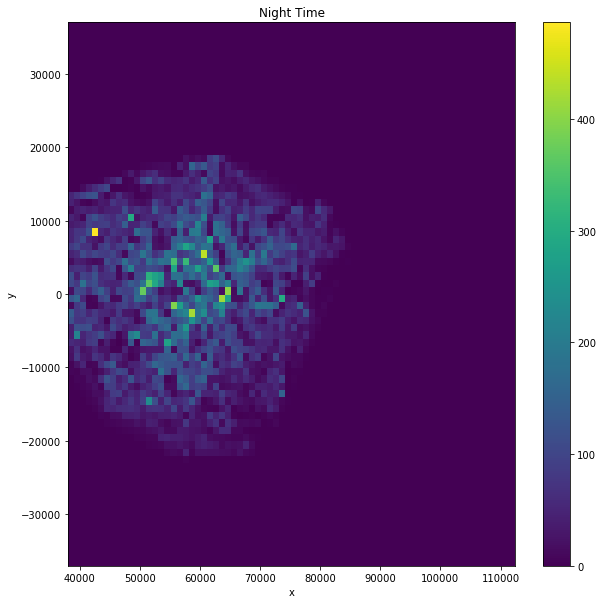

In [22]:
pc_plot(wrf_X, wrf_Y,ds_base['PopDensNightTime_SUEWS'.upper()].values[0,:,:],'Night Time')

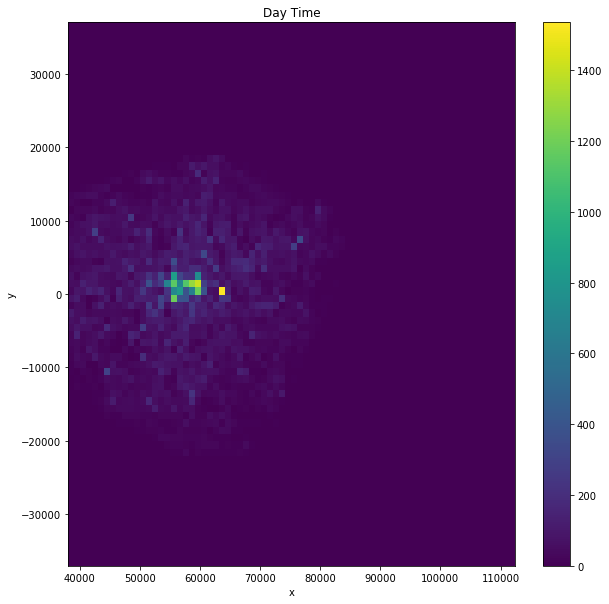

In [23]:
pc_plot(wrf_X, wrf_Y,ds_base['PopDensDayTime_SUEWS'.upper()].values[0,:,:],'Day Time')

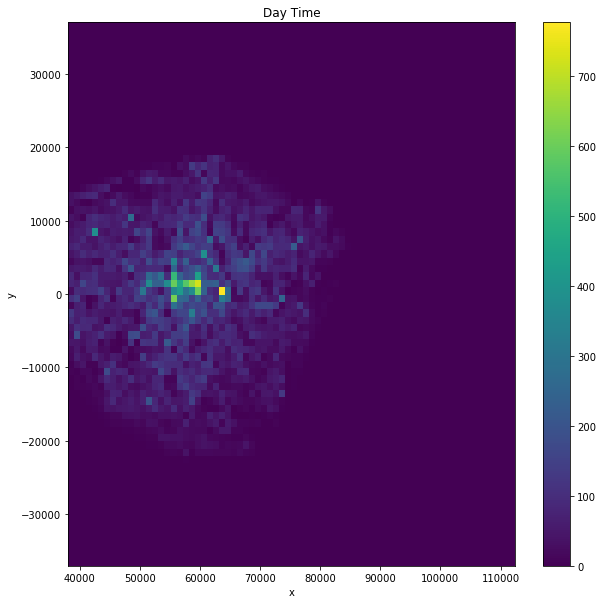

In [24]:
zz=(ds_base['PopDensDayTime_SUEWS'.upper()].values[0,:,:]+ds_base['PopDensNightTime_SUEWS'.upper()].values[0,:,:])/2
pc_plot(wrf_X, wrf_Y,zz,'Day Time')

In [25]:
def pc_plot_2(grid_x, grid_y,new_Z,name,ax):
    #plt.figure(figsize=(10,10))
    c=ax.pcolor(grid_x, grid_y,new_Z)
    #plt.colorbar()
    #plt.title(name)
    #plt.ylabel('y')
    #plt.xlabel('x')
    return c

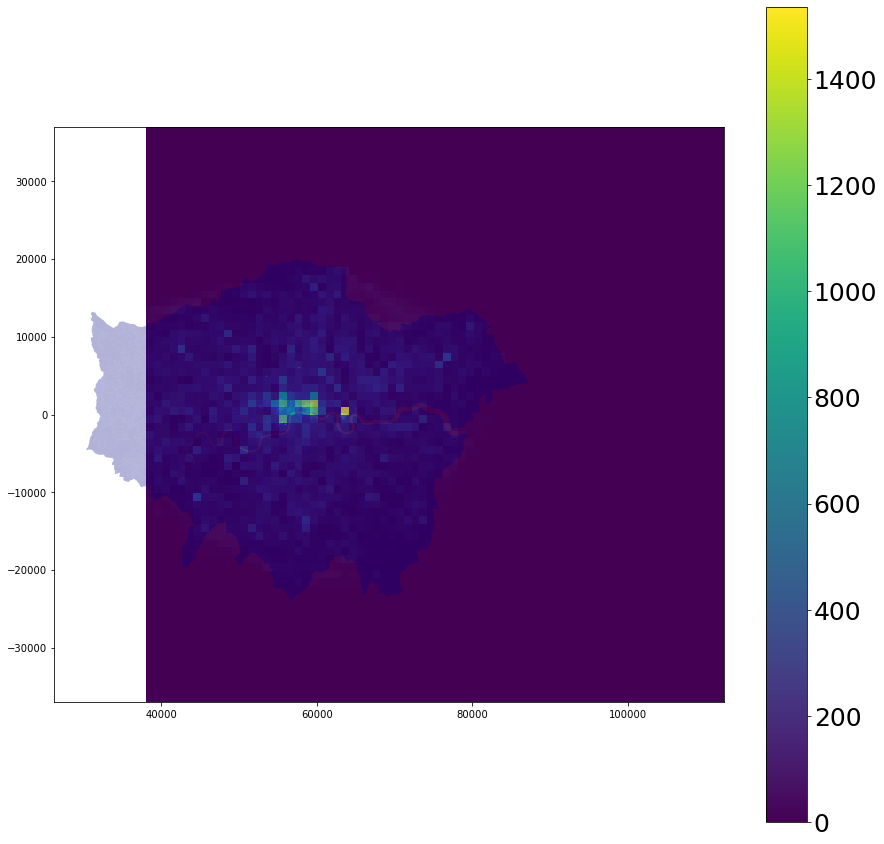

In [26]:
fig, ax = plt.subplots(1, 1,figsize=(15,15))
plt.rc('font', size=25)
c=pc_plot_2(wrf_X, wrf_Y,ds_base['PopDensDayTime_SUEWS'.upper()].values[0,:,:],'new',ax)
shapefile_converted_2.plot('Work_dens',cmap='jet',ax=ax,alpha=0.3,
               legend=False)
fig.colorbar(c, ax=ax)
plt.savefig('Day.png',dpi=400)

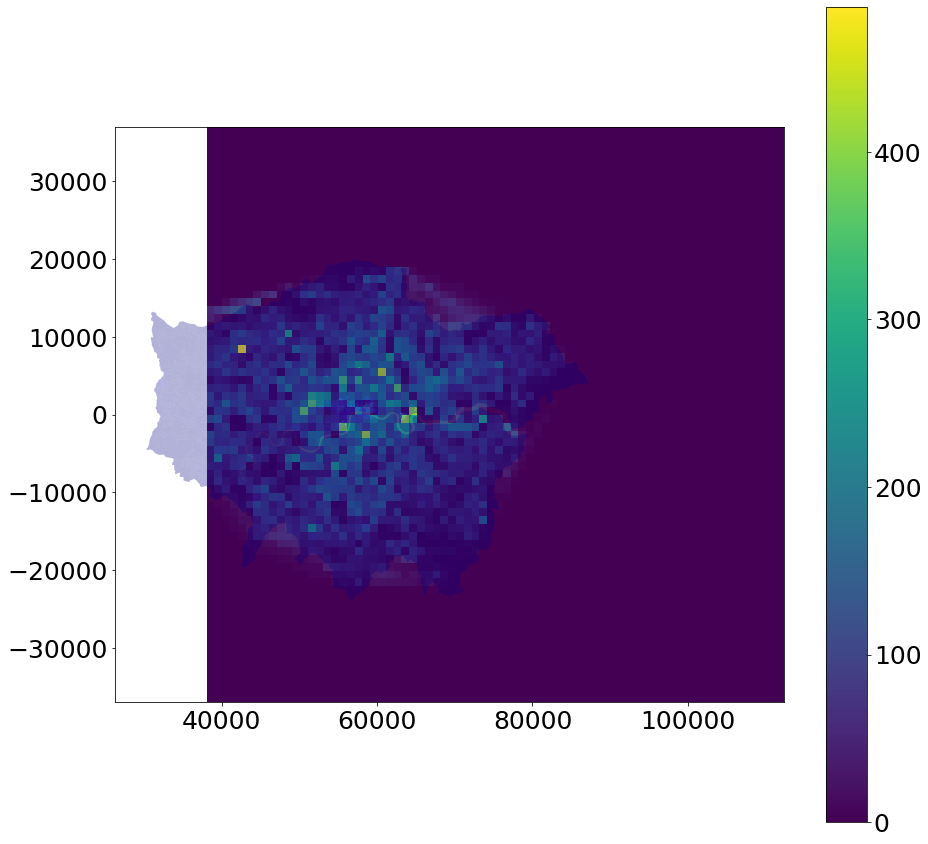

In [27]:
fig, ax = plt.subplots(1, 1,figsize=(15,15))
plt.rc('font', size=25)
c=pc_plot_2(wrf_X, wrf_Y,ds_base['PopDensNightTime_SUEWS'.upper()].values[0,:,:],'new',ax)
shapefile_converted_2.plot('Work_dens',cmap='jet',ax=ax,alpha=0.3,
               legend=False)
fig.colorbar(c, ax=ax)
plt.savefig('Night.png',dpi=400)

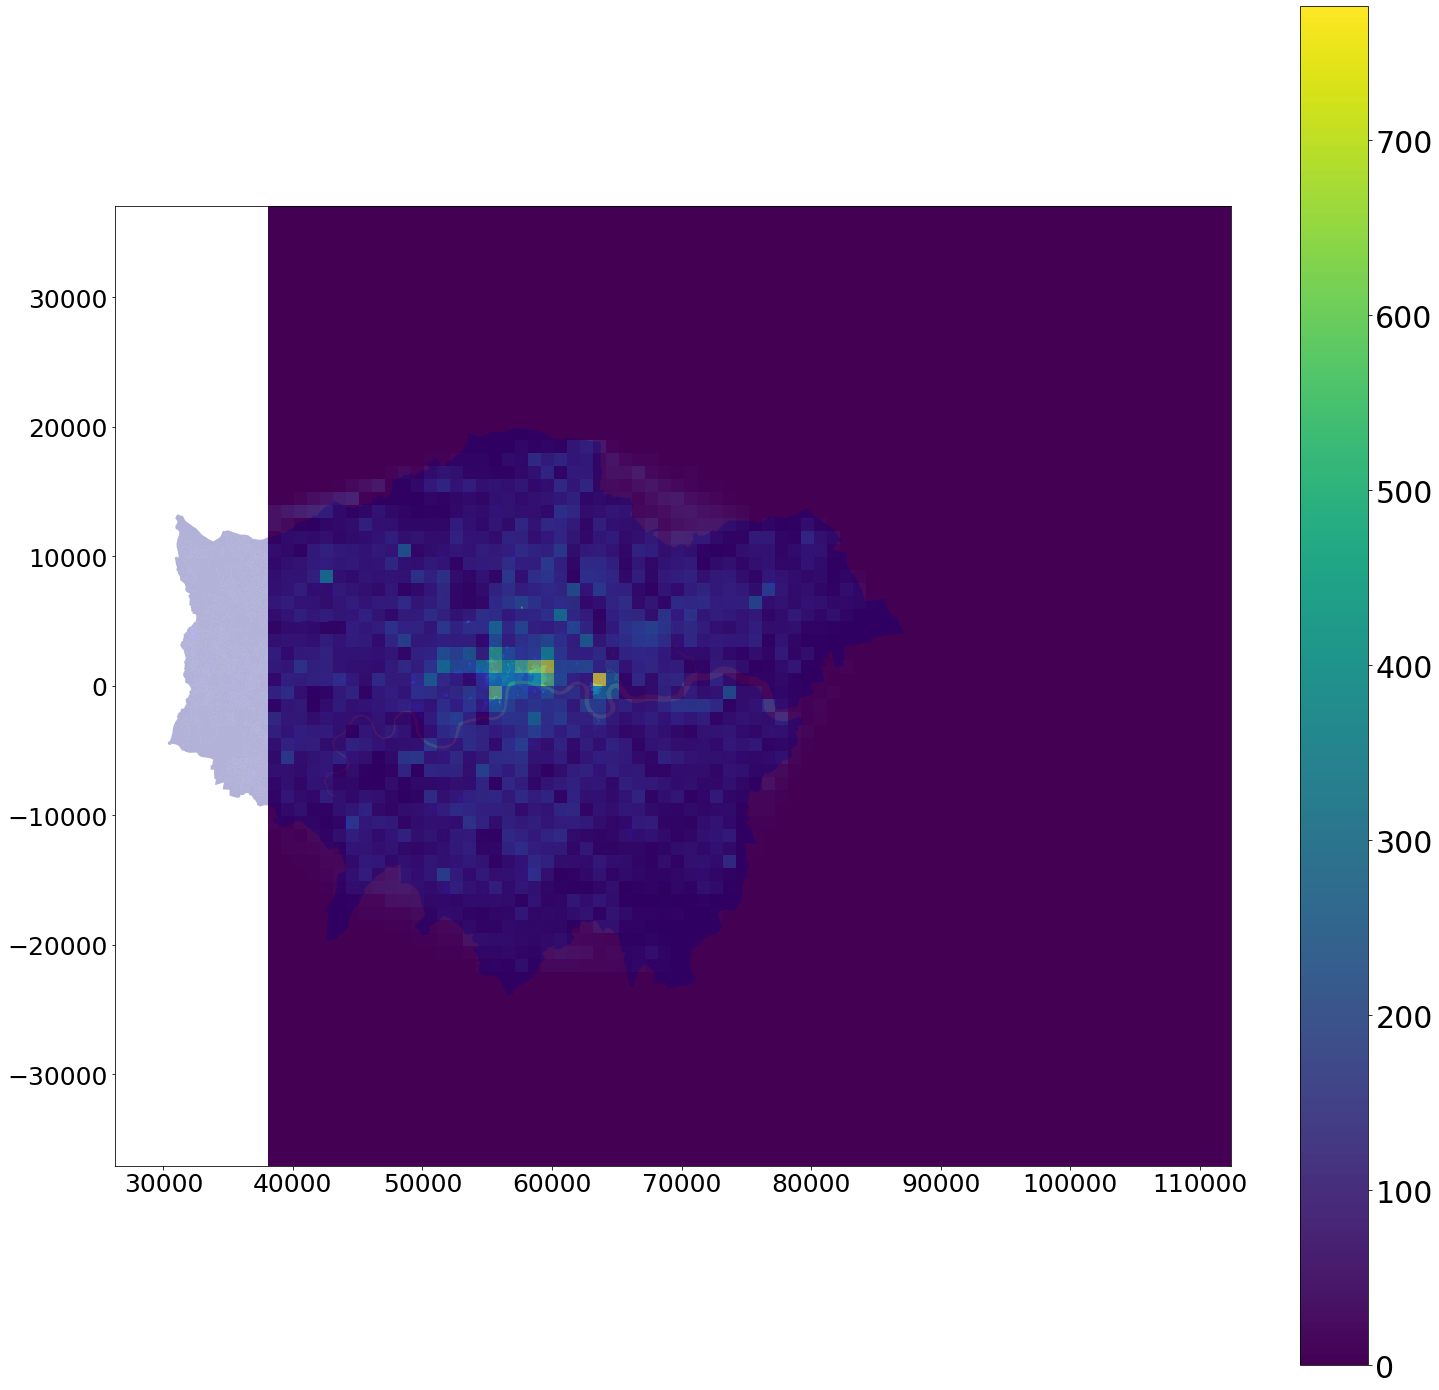

In [28]:
fig, ax = plt.subplots(1, 1,figsize=(25,25))
plt.rc('font', size=30)
c=pc_plot_2(wrf_X, wrf_Y,zz,'new',ax)
shapefile_converted_2.plot('Work_dens',cmap='jet',ax=ax,alpha=0.3,
               legend=False)
fig.colorbar(c, ax=ax)
plt.savefig('Avg.png',dpi=400)

In [29]:
ds_merged = ds_base.update(ds_base)    

for var in ds_merged.data_vars.keys():
    if 'coordinates' in ds_merged[var].attrs:
        del ds_merged[var].attrs['coordinates']
        
file_out = x_file+'.new'

ds_merged.to_netcdf(file_out,
                    mode='w', format='NETCDF3_64BIT')
print('SUEWS input has been added to:' + file_out)

SUEWS input has been added to:wrfinput_d03.suews.new
